In [1]:
import geopandas
import geojson
import json
import sys
import shapely
from shapely.geometry import shape
from haversine import haversine, Unit
from shapely.geometry import Polygon
from shapely.geometry import Point
from shapely.geometry import LineString
from math import ceil
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
import geopy
import geopy.distance
import pyproj
from shapely.ops import transform
from functools import partial

In [2]:
myshpfile = geopandas.read_file('layers\\POLYGON.shp')
myshpfile.to_file('myJson.geojson', driver='GeoJSON')
with open('myJson.geojson') as f:
    features = json.load(f)["features"]
maparea = ([shape(feature["geometry"]).buffer(0) for feature in features])

tfm = partial(pyproj.transform, 
              pyproj.Proj(init="epsg:4326"), 
              pyproj.Proj(init="epsg:3031"))
#for _ in range(4)
outer_rect = shapely.ops.transform(tfm, maparea[0])
print(outer_rect)
obstacles = []
for _ in range(1,4):
    obstacles.append(shapely.ops.transform(tfm, maparea[_]))

In [3]:
obstacles = []
for _ in range(1,4):
    obstacles.append(maparea[_])
print(obstacles)

[<shapely.geometry.polygon.Polygon object at 0x00000258611A2C48>, <shapely.geometry.polygon.Polygon object at 0x00000258611A2DC8>, <shapely.geometry.polygon.Polygon object at 0x00000258611E1508>]


In [4]:
outer_rect = maparea[0].bounds

In [5]:
print(outer_rect)

(72.79214859008789, 18.920089944412993, 72.84896850585938, 19.025283423553358)


In [6]:
#haversine takes lat,long  whereas the pts are long,lat


In [7]:
def gridpoints(rect,dist):
    height = haversine((rect[1],rect[0]),(rect[3],rect[0]))
    length = haversine((rect[1],rect[0]),(rect[1],rect[2]))
    d = geopy.distance.distance(kilometers = dist)
    horizontalcells = ceil(length/dist)
    verticalcells = ceil(height/dist)
    
    latitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(verticalcells):
        latitudelist.append(start)
        final = d.destination(point=start, bearing=0)
        start = final
    latitudelist.append(start)
    
    longitudelist = []
    start = geopy.Point(rect[1],rect[0])
    for _ in range(horizontalcells):
        longitudelist.append(start)
        final = d.destination(point=start, bearing=90)
        start = final
    longitudelist.append(start)
    
    return latitudelist,longitudelist,verticalcells,horizontalcells

In [8]:
latitudelist,longitudelist,vertical,horizontal = gridpoints(outer_rect,0.1) #binding rectangle and distance are sent as parameters

In [9]:
print(longitudelist[horizontal][1])

72.84910583784675


In [10]:
vertical

117

In [11]:
c = np.ones([vertical,horizontal],dtype = bool)

In [12]:
mapboundary = maparea[0]

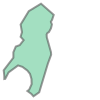

In [13]:
maparea[0]

In [14]:
boundingrectangle = Polygon([(longitudelist[0][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[0][0]),(longitudelist[horizontal][1],latitudelist[vertical][0]),(longitudelist[0][1],latitudelist[vertical][0])]) 

In [15]:
print(boundingrectangle)

POLYGON ((72.79214859008789 18.92008994441299, 72.84910583784675 18.92008994441299, 72.84910583784675 19.02578888118662, 72.79214859008789 19.02578888118662, 72.79214859008789 18.92008994441299))


In [16]:
maptraversearea = boundingrectangle.difference(mapboundary)

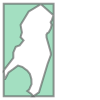

In [17]:
maptraversearea

In [18]:
shapes = []


In [19]:
shapes.append(Polygon([(0.5, 0.5),(1.5, 0.5),(1.5, 1.5),(0.5, 1.5)]))

In [20]:
shapes.append(Polygon([(3, 3),(5, 6.5),(4,4)]))

In [21]:
shapes.append(LineString([(20, 60), (50, 60)]))

In [22]:
shapes.append(Polygon([(20,20),(20,40),(40,40),(40,20)]))
shapes.append(Polygon([(30,30),(30,45),(45,45),(45,30)]))

In [23]:
shapes.append(Polygon([(60.1,60.1),(60.7,60.7),(60.1,60.7)]))

In [24]:
#shapes

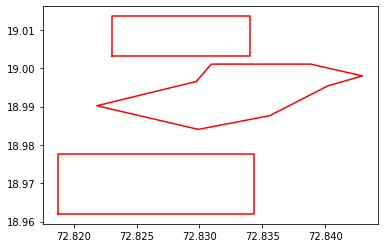

In [25]:
for _ in obstacles:
    x,y = _.exterior.xy
    plt.plot(x,y, color = "red")
#plt.plot(latitudelist,longitudelist,color = "black")

In [56]:
c = np.ones([horizontal,vertical],dtype = bool)
lookup_c = [[0 for x in range(horizontal)] for y in range(vertical)] 

In [74]:
for x in range(len(latitudelist)-1):
    for y in range(len(longitudelist)-1):
        square = Polygon([(longitudelist[y][1],latitudelist[x][0]),(longitudelist[y+1][1],latitudelist[x][0]),(longitudelist[y+1][1],latitudelist[x+1][0]),(longitudelist[y][1],latitudelist[x+1][0])]) 
        lookup_c[x][y] = square.centroid
        # storing value of centre point
        #print(square)
        if(not mapboundary.contains(square)):
            c[y,x] = False
        #a,b = square.exterior.xy
        #plt.plot(a,b, color = "black",alpha = 0.2)
        for _ in obstacles:
            if(square.intersects(_)):
                z = square.intersection(_)
                if(not z.is_empty):
                    #print(y,x)
                    c[y,x] = False
            elif(square.contains(_)):
                c[y,x] = False
#for _ in shapes:
#  x,y = _.exterior.xy
#   plt.plot(x,y, color = "red")

TypeError: 'Point' object is not subscriptable

In [60]:
print(lookup_c[0][0])

POINT (72.79262323381941 18.92054165182155)


In [61]:
print(c)

[[False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]
 ...
 [False False False ... False False False]
 [False False False ... False False False]
 [False False False ... False False False]]


imgshow_(c)

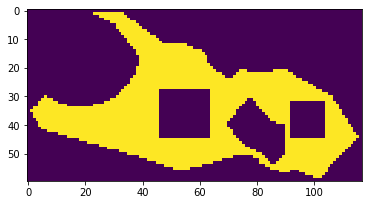

In [62]:
import matplotlib.pyplot as plt
a = plt.imshow(c, interpolation = 'nearest')

In [63]:
import pyvisgraph as vg

In [185]:
x,y = obstacles[0].exterior.coords.xy
for _ in range(len(x)):
    print(x[_],y[_])

0.5 0.5
1.5 0.5
1.5 1.5
0.5 1.5
0.5 0.5


In [64]:
polygons = []
for shape in obstacles:
    polygon = []
    if(not shape.geom_type=="Polygon"):
        x,y = shape.xy
        print(x,y)
    else:
        x, y = shape.exterior.coords.xy
    for _ in range(len(x)):
        polygon.append(vg.Point(x[_], y[_]))
        polygons.append(polygon)

In [65]:
print(polygons)

[[Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00), Point(72.82, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00), Point(72.82, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00), Point(72.82, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00), Point(72.82, 19.00)], [Point(72.82, 19.00), Point(72.82, 19.01), Point(72.83, 19.01), Point(72.83, 19.00), Point(72.82, 19.00)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96), Point(72.82, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96), Point(72.82, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96), Point(72.82, 18.96)], [Point(72.82, 18.96), Point(72.82, 18.98), Point(72.83, 18.98), Point(72.83, 18.96), Point(72.82, 18.96)], [Point(72.82, 18.96), Point(72.82, 1

In [66]:
graph = vg.VisGraph()

In [67]:
graph.build(polygons)

100%|██████████| 2/2 [00:00<00:00, 249.49it/s]


In [82]:
initial = lookup_c[40][40].xy
final = lookup_c[100][50].xy
print(initial[1][0])

18.956678174218688


In [83]:
 shortest = graph.shortest_path(vg.Point(initial[0][0],initial[1][0]), vg.Point(final[0][0],final[1][0]))

In [84]:
print(shortest)

[Point(72.83, 18.96), Point(72.83, 18.96), Point(72.84, 19.00), Point(72.84, 19.01)]


In [85]:
path_distance = 0
prev_point = shortest[0]
for point in shortest[1:]:
    path_distance += haversine((prev_point.y, prev_point.x), (point.y, point.x))
    prev_point = point

In [86]:
print(path_distance)

6.280827001913147


In [194]:
list_of_fuelstations = []

In [195]:
circles = []

In [196]:
def fuelchecker(mapboundary):
    for x in list_of_fuelstations:
        circles.append(x.buffer(distance))
    fuelling_range = unary_union(circles)
    if(mapboundary.within(fuelling_range)):
        print("All good")
    else:
        print("Some Points are outside the fuelling station!")
        print("Taking them as obstacles")
        mapboundary = mapboundary.intersection(feulling_range)

In [197]:
fuelchecker(mapboundary)

Some Points are outside the fuelling station!
Taking them as obstacles


NameError: name 'feulling_range' is not defined

In [198]:
import geopy
import geopy.distance

In [127]:
start = geopy.Point(-48.853, 2.349)

In [128]:
d = geopy.distance.distance(kilometers = 1)

In [132]:
final = d.destination(point=start, bearing=90)

In [133]:
print(final)

48 51m 10.7971s S, 2 21m 45.4551s E


In [134]:
final

Point(-48.85299919479592, 2.362626412505501, 0.0)